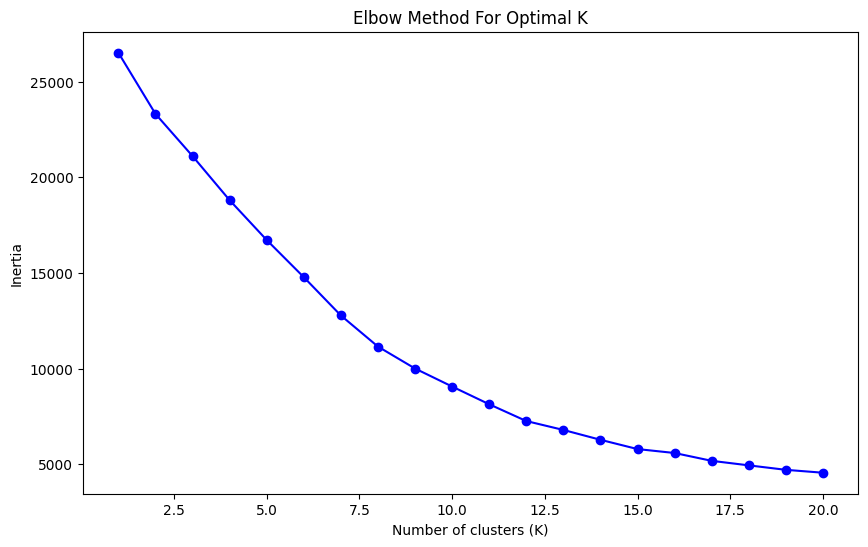

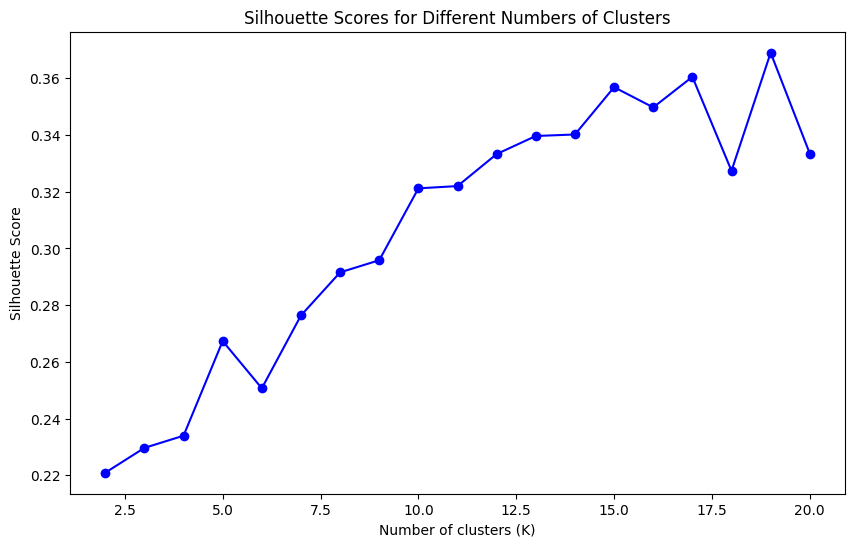

The optimal number of clusters is: 19
Number of stocks in each cluster:
Cluster
0     377
1      70
2     342
3     357
4      32
5       5
6       1
7     919
8     282
9     413
10      2
11     17
12     35
13     95
14      2
15      3
16    605
17    221
18     10
dtype: int64
Small clusters identified for merging: [4, 5, 6, 10, 11, 12, 14, 15, 18]
Final number of stocks in each cluster after merging:
Cluster
0     412
1      80
2     342
3     359
7     936
8     282
9     413
13    130
16    613
17    221
dtype: int64

Final Cluster Summary (Mean):
              Mkt Cap       Price       TTMPE      Ind PE      P/BV  \
Cluster                                                               
0        47729.554889  532.290340   24.202732   23.597728  2.918408   
1        11873.868089  461.703375   35.456919  111.816173  4.288918   
2         4502.637466  359.087076   26.952714   30.856739  3.251521   
3         3661.534049  408.202479   25.882266   57.212173  8.964475   
7         60

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the data
file_path = '/content/Copy of Raw_Data_of_all_listed_companies(1).xlsx'
raw_data_df = pd.read_excel(xls, sheet_name='Raw Data of stocks')

# Clean the data: Remove unnecessary rows and columns
cleaned_df = raw_data_df.iloc[2:, :]
cleaned_df.columns = ['No', 'Company', 'Sector', 'Industry', 'House', 'Mkt Cap', 'Price', 'TTMPE', 'Ind PE', 'P/BV'] + list(cleaned_df.columns[10:])
cleaned_df = cleaned_df.reset_index(drop=True)
cleaned_df = cleaned_df.dropna(subset=['Company'])

# Define sector mapping
sector_mapping = {
    'Crude Oil': 'Energy',
    'IT': 'Technology',
    'Bank': 'Financials',
    'FMCG': 'Consumer Goods',
    'Telecom': 'Technology',
    'Insurance': 'Financials',
    'Infrastructure': 'Industrials',
    'Finance': 'Financials',
    'Diamond  &  Jewellery': 'Consumer Goods',
    'Chemicals': 'Materials',
    'Trading': 'Industrials',
    'Automobile & Ancillaries': 'Industrials',
    'Construction Materials': 'Industrials',
    'Healthcare': 'Healthcare',
    'Power': 'Energy',
    'Retailing': 'Consumer Goods',
    'Mining': 'Materials',
    'Logistics': 'Industrials',
    'Iron & Steel': 'Materials',
    'Capital Goods': 'Industrials',
    'Realty': 'Industrials',
    'Diversified': 'Miscellaneous',
    'Non - Ferrous Metals': 'Materials',
    'Aviation': 'Industrials',
    'Gas Transmission': 'Energy',
    'Inds. Gases & Fuels': 'Energy',
    'Agri': 'Consumer Goods',
    'Electricals': 'Industrials',
    'Alcohol': 'Consumer Goods',
    'Hospitality': 'Consumer Goods',
    'Plastic Products': 'Industrials',
    'Ship Building': 'Industrials',
    'Textile': 'Consumer Goods',
    'Consumer Durables': 'Consumer Goods',
    'Ratings': 'Financials',
    'Miscellaneous': 'Miscellaneous',
    'Media & Entertainment': 'Technology',
    'Abrasives': 'Materials',
    'Business Services': 'Industrials',
    'Paper': 'Materials',
    'Ferro Manganese': 'Materials',
    'Education & Training': 'Miscellaneous',
    'Photographic Product': 'Miscellaneous',
}

# Apply the sector mapping to the dataset
cleaned_df['Major Sector'] = cleaned_df['Sector'].map(sector_mapping)

# Select relevant columns for clustering
features_df = cleaned_df[['Mkt Cap', 'Price', 'TTMPE', 'Ind PE', 'P/BV', 'Major Sector', 'Industry']]

# Convert numeric columns to numeric types and handle any conversion errors
numeric_cols = ['Mkt Cap', 'Price', 'TTMPE', 'Ind PE', 'P/BV']
features_df[numeric_cols] = features_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values in numeric columns with the median
features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].median())

# Encode categorical variables 'Major Sector' and 'Industry'
for col in ['Major Sector', 'Industry']:
    features_df[col] = features_df[col].fillna(features_df[col].mode()[0])
    label_encoder = LabelEncoder()
    features_df[col] = label_encoder.fit_transform(features_df[col])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Elbow Method to determine the optimal number of clusters
inertia = []
K_range = range(1, 21)
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

# Silhouette Scores to refine the number of clusters
silhouette_scores = []
for K in range(2, 21):
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

# Determine the best number of clusters based on the highest Silhouette Score
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 because range starts at 2

print(f'The optimal number of clusters is: {optimal_clusters}')

# Train the final model using the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
features_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the number of stocks in each cluster
cluster_counts = features_df.groupby('Cluster').size()
print("Number of stocks in each cluster:")
print(cluster_counts)

# Step 1: Define a threshold for small clusters
small_cluster_threshold = 50  # Set threshold such that a minimum of 50 stocks are there in each cluster

# Identify small clusters
small_clusters = cluster_counts[cluster_counts < small_cluster_threshold].index
large_clusters = cluster_counts[cluster_counts >= small_cluster_threshold].index

print(f"Small clusters identified for merging: {small_clusters.tolist()}")

# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Step 2: Merge small clusters into the closest larger cluster
for small_cluster in small_clusters:
    # Get the centroid of the small cluster
    small_centroid = centroids[small_cluster]

    # Calculate the distance to all large cluster centroids
    distances = np.linalg.norm(centroids[large_clusters] - small_centroid, axis=1)

    # Find the closest large cluster
    closest_large_cluster = large_clusters[np.argmin(distances)]

    # Reassign all stocks in the small cluster to the closest large cluster
    features_df.loc[features_df['Cluster'] == small_cluster, 'Cluster'] = closest_large_cluster

# Step 3: Recalculate the number of stocks in each cluster after merging
final_cluster_counts = features_df.groupby('Cluster').size()

print("Final number of stocks in each cluster after merging:")
print(final_cluster_counts)

# Step 4: Recalculate and display the final metrics for each cluster
# Calculate the mean of each feature per cluster for numeric columns
final_cluster_summary = features_df.groupby('Cluster').mean()

# Reintroduce original categorical values by taking the mode (most frequent value) for Major Sector and Industry
final_cluster_sectors = features_df.groupby('Cluster')['Major Sector'].agg(lambda x: pd.Series.mode(x)[0])
final_cluster_industries = features_df.groupby('Cluster')['Industry'].agg(lambda x: pd.Series.mode(x)[0])

# Combine these with the final cluster summary
final_cluster_summary['Major Sector'] = final_cluster_sectors
final_cluster_summary['Industry'] = final_cluster_industries

# Display the final cluster summary
print("\nFinal Cluster Summary (Mean):")
print(final_cluster_summary)

# Optionally, save the final clustered data
# features_df.to_csv('final_clustered_stocks.csv', index=False)


In [ ]:
# Step 4: Rename the cluster indices sequentially
new_cluster_labels = {old_label: new_label for new_label, old_label in enumerate(features_df['Cluster'].unique())}
features_df['Cluster'] = features_df['Cluster'].map(new_cluster_labels)

# Recalculate the final cluster counts with the new labels
final_cluster_counts = features_df.groupby('Cluster').size()

print("Final number of stocks in each cluster after renaming:")
print(final_cluster_counts)

# Update the final cluster summary with the new labels
final_cluster_summary = features_df.groupby('Cluster').mean()

# Reintroduce original categorical values by taking the mode (most frequent value) for Major Sector and Industry
final_cluster_sectors = features_df.groupby('Cluster')['Major Sector'].agg(lambda x: pd.Series.mode(x)[0])
final_cluster_industries = features_df.groupby('Cluster')['Industry'].agg(lambda x: pd.Series.mode(x)[0])

# Combine these with the final cluster summary
final_cluster_summary['Major Sector'] = final_cluster_sectors
final_cluster_summary['Industry'] = final_cluster_industries

# Display the final cluster summary with renamed clusters
print("\nFinal Cluster Summary (Mean) with Renamed Clusters:")
print(final_cluster_summary)


Final number of stocks in each cluster after renaming:
Cluster
0    412
1    936
2     80
3    342
4    413
5    613
6    221
7    359
8    130
9    282
dtype: int64

Final Cluster Summary (Mean) with Renamed Clusters:
              Mkt Cap       Price       TTMPE      Ind PE      P/BV  \
Cluster                                                               
0        47729.554889  532.290340   24.202732   23.597728  2.918408   
1         6035.927555  968.207746   30.719439   48.570483  4.039752   
2        11873.868089  461.703375   35.456919  111.816173  4.288918   
3         4502.637466  359.087076   26.952714   30.856739  3.251521   
4         3198.273121  251.039637   21.179851   31.863837  2.502031   
5         5882.759569  682.227586   26.631393   34.112262  4.105477   
6         5533.936425  484.137511   39.741266   76.774783  4.856220   
7         3661.534049  408.202479   25.882266   57.212173  8.964475   
8         2903.738097  378.913538  411.866544   52.545700  5.291667   


In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

# Apply PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the PCA components and the cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = features_df['Cluster']
pca_df['Company'] = cleaned_df['Company']  # Include company names for better visualization

# Plot the clusters using Plotly
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Cluster',
    hover_data=['Company'],
    title='PCA of Final Stock Clusters'
)
fig.show()


In [ ]:
import plotly.figure_factory as ff

# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Plot the heatmap
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.values,
    x=list(correlation_matrix.columns),
    y=list(correlation_matrix.index),
    colorscale='Viridis',
    showscale=True
)

fig.update_layout(
    title='Heatmap of Feature Correlations',
    xaxis_title='Features',
    yaxis_title='Features'
)

fig.show()


In [ ]:
# Bar plot of the number of stocks in each cluster
fig = px.bar(
    final_cluster_counts.reset_index(),
    x='Cluster',
    y=0,
    labels={0: 'Number of Stocks'},
    title='Number of Stocks in Each Final Cluster'
)
fig.show()


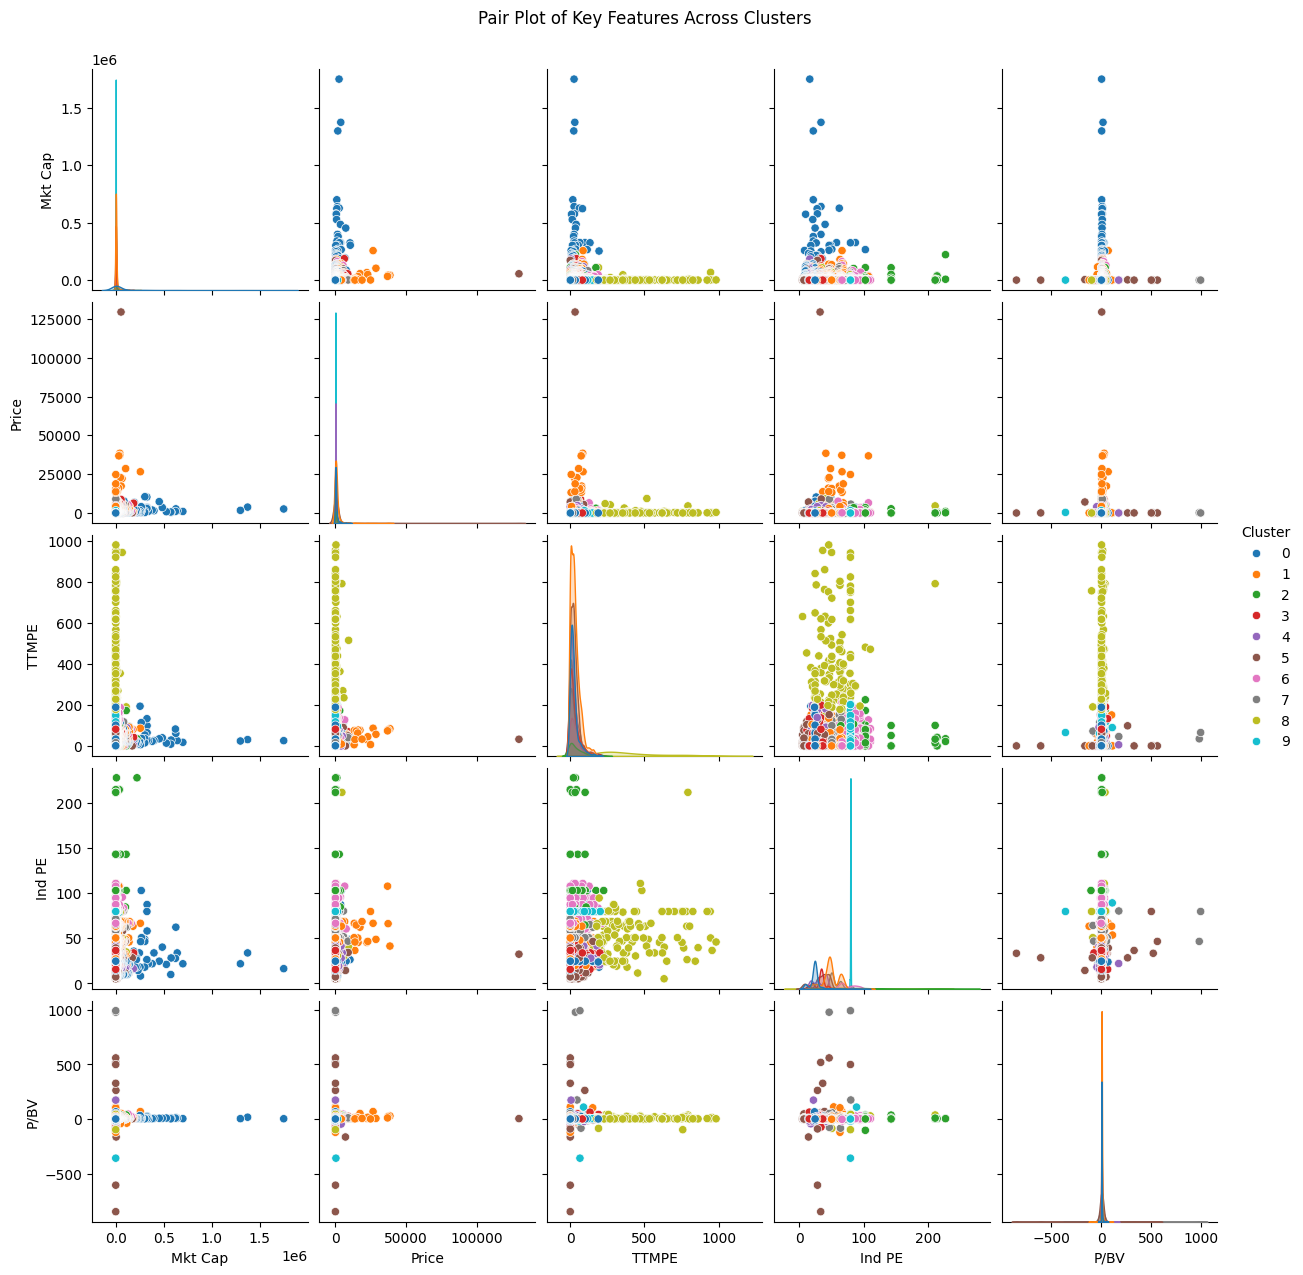

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a few key features for the pair plot
key_features = ['Mkt Cap', 'Price', 'TTMPE', 'Ind PE', 'P/BV', 'Cluster']

# Create a pair plot
sns.pairplot(features_df[key_features], hue='Cluster', palette='tab10')
plt.suptitle('Pair Plot of Key Features Across Clusters', y=1.02)
plt.show()


In [ ]:
# Check columns in features_df
print("Columns in features_df:", features_df.columns)


Columns in features_df: Index(['Mkt Cap', 'Price', 'TTMPE', 'Ind PE', 'P/BV', 'Major Sector',
       'Industry', 'Cluster'],
      dtype='object')


In [ ]:
features_df


,Mkt Cap,Price,TTMPE,Ind PE,P/BV,Major Sector,Industry,Cluster
0,1.748938e+06,2584.85,25.5334,16.405701,2.3281,1,103,0
1,1.373046e+06,3794.95,30.7486,33.828521,16.4162,7,75,0
2,1.297972e+06,1709.65,23.8271,21.809466,3.0983,2,15,0
3,6.989938e+05,996.45,17.3977,21.809466,3.0695,2,15,0
4,6.403518e+05,1542.85,25.7469,33.828521,7.9278,7,75,0
...,...,...,...,...,...,...,...,...
3783,1.680782e+00,116.00,0.0000,66.570040,-3.2045,0,33,6
3784,1.612038e+00,7.29,0.0000,79.632711,-0.5564,4,124,9
3785,1.485500e+00,29.71,0.0000,24.675177,0.5342,2,59,0
3786,8.227000e-01,4.33,0.0000,79.632711,-0.0023,4,124,9
